# Data Generation

First we pick out the dimensions and scales:

A_scale = ( (GM_sun_length^5 / light_second^2)^(1/3) ) / (kilo_parsec)

f_scale = ( GM_sun^(1/2) / ((r_scale_units)^(3/2)))

In [80]:
A_scale = 1.385328279341387e-20
f_scale = 0.011520088541326409

A_i = lambda Mc, d: A_scale * (Mc**(5/3) / d)  # A_i(Mc, d)
A_i_f = lambda Mc, d, f: A_scale * (Mc**(5/3) / d) * (np.pi * f)**(2/3)  # A_i(Mc, d, f)
f_i = lambda Mc, r: f_scale * np.sqrt(Mc / np.pi) * r**(-3/2)  # f_i(Mc, r)

import numpy as np
import matplotlib.pyplot as plt

# Define sample_rate, duration, ϕ, Mc, r, d
sample_rate = 0.25
duration = 10_000

# Generate time values
ts = np.linspace(0, duration, int(sample_rate * duration))

# Define the S_forward function
S_forward = lambda t, f, phi, A: A * np.sin((2 * np.pi * f * t) + phi)

# Sampling from TruncatedPowerLaw

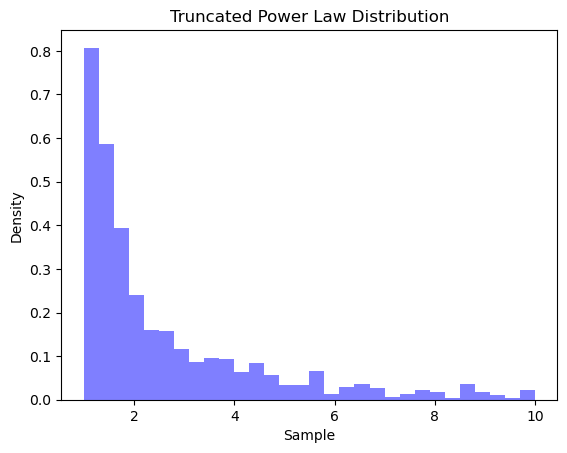

In [99]:
import numpy as np
from scipy.stats import expon

class TruncatedPowerLaw:
    def __init__(self, alpha, a, b):
        self.alpha = alpha
        self.a = a
        self.b = b
        self.cdf_a = expon.cdf(a)
        self.cdf_b = expon.cdf(b)
        self.norm_const = 1 / (self.cdf_b - self.cdf_a)

    def logpdf(self, x):
        if x < self.a or x > self.b:
            return -np.inf  # Outside of the defined range
        else:
            return np.log(self.norm_const) - (self.alpha + 1) * np.log(x)

    def sample(self, size=1):
        u = np.random.uniform(0, 1, size)
        z = u * (self.b**(self.alpha + 1) - self.a**(self.alpha + 1)) + self.a**(self.alpha + 1)
        return z**(1/(self.alpha + 1))  # Inverse CDF sampling

# Example usage:
alpha = -2.0
a = 1.0
b = 10.0

# Create a truncated power-law distribution
tpl_dist = TruncatedPowerLaw(alpha, a, b)

# Generate random samples from the distribution
samples = tpl_dist.sample(1000)

# Plot a histogram of the samples
import matplotlib.pyplot as plt
plt.hist(samples, bins=30, density=True, alpha=0.5, color='b')
plt.xlabel('Sample')
plt.ylabel('Density')
plt.title('Truncated Power Law Distribution')
plt.show()


In [100]:
import pandas as pd

Lambda = {'alpha' : -1.2, 'beta' : -2.0}
limits = {'Mc' : [0.5, 1.4], 'r': [0.5, 20], 'd':[1, 50], 'phi':[0,2*np.pi]}


shape = (1000,)

PopulationInjection = dict(
                            Mc = TruncatedPowerLaw(Lambda['alpha'], *limits["Mc"]).sample(shape),
                            r = TruncatedPowerLaw(Lambda['beta'], *limits["r"]).sample(shape),
                            d = TruncatedPowerLaw(1.0, *limits["d"]).sample(shape),
                            phi = np.random.rand(*shape)*(limits["phi"][1] - limits["phi"][0]) + limits["phi"][0]
                          )




pd.DataFrame(PopulationInjection)

,Mc,r,d,phi
0,1.275443,0.511508,1.031408,1.318470
1,0.992927,6.793624,7.412416,6.075134
2,0.846780,1.570355,40.304066,6.104109
3,1.020380,3.605711,36.435737,4.120128
4,0.929881,0.723076,44.978026,6.243553
...,...,...,...,...
995,0.730913,1.946789,39.786647,4.665386
996,1.073201,0.715716,47.211086,4.487505
997,0.500840,1.394087,45.273732,5.292073
998,0.846785,0.568837,49.076468,0.103034


# Generate their Time Series and sum them all together

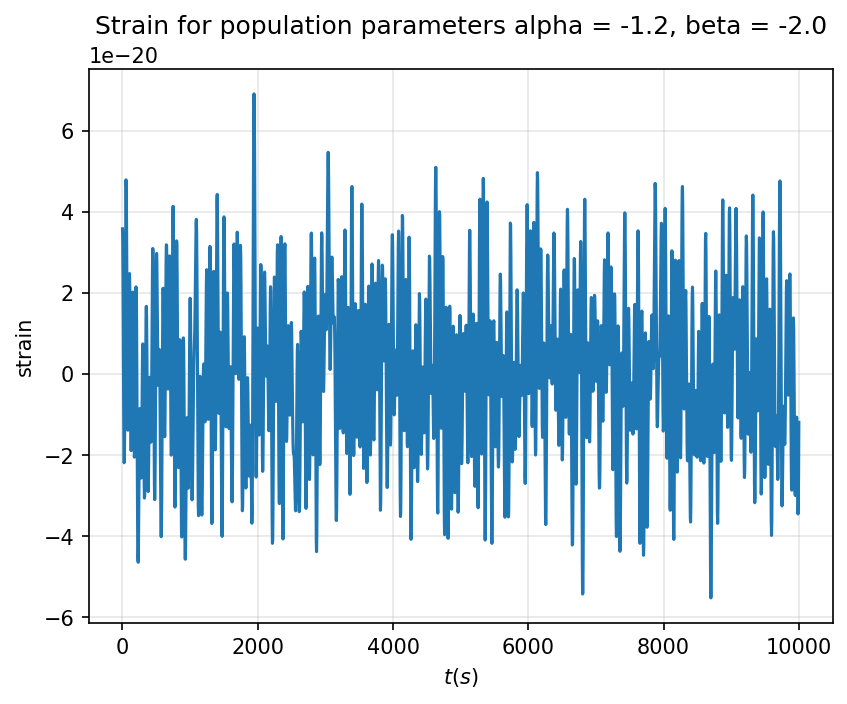

In [108]:
import matplotlib.pyplot as plt

Mc, r, d, phi = PopulationInjection['Mc'], PopulationInjection['r'], PopulationInjection['d'], PopulationInjection['phi']


fig, ax = plt.subplots(dpi=150)
plt.plot(ts, S_forward(ts[:, None], f_i(Mc, r), phi, A_i(Mc, d)).sum(axis=-1))
plt.xlabel(r"$t (s)$")
plt.ylabel(r"strain")
plt.title(f"Strain for population parameters alpha = {np.round(Lambda['alpha'],1)}, beta = {np.round(Lambda['beta'],1)}")
plt.grid(alpha=0.3)
plt.show()

In [ ]:
[]

# Usage

In [1]:
from datageneration import PowerLawChirpPowerLawSeperation, DataLoader

In [2]:
import numpy as np
from datageneration import PowerLawChirpPowerLawSeperation

## Define the ranges over which the population distribution exists

limits = {'chirp_mass':          [0.5, 1.4],  # In solar masses
          'seperation':          [0.5, 20],   # In 1e8 meters
          'luminosity_distance': [1, 50],     # In kilo parsecs
          'phase':               [0, 2*np.pi]}

## Instantiate the population distribution object

dist = PowerLawChirpPowerLawSeperation(limits=limits, 
                                       distance_power_law_index=1)   # p(d) ~ d

In [3]:
# Get samples from a given hyperparameter set
import pandas as pd

Lambda = {'alpha' : -1.01, 'beta' : -2.0}
pd.DataFrame(dist.generate_samples(Lambda, size=10))

,chirp_mass,seperation,luminosity_distance,phase
0,1.010555,12.266361,19.262574,1.864931
1,0.648297,0.582498,49.690829,3.311077
2,0.845745,0.578346,34.413344,0.862399
3,0.916300,1.399018,22.753180,3.459496
4,0.516232,8.562882,21.936307,3.485511
5,1.222579,1.584017,49.564790,4.483874
6,0.708602,0.614968,36.261713,5.581316
7,0.571148,0.847846,40.087377,5.108684
8,1.056150,0.788726,43.401461,4.826415
9,0.652015,7.406447,46.564997,2.268895


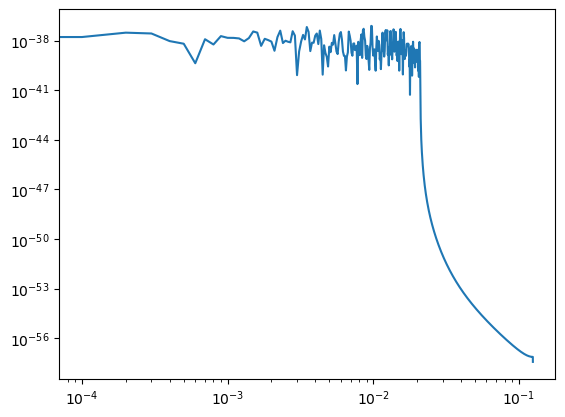

In [4]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

def calculate_psd(strain, time, fs):
    f, psd = welch(strain, fs=fs, nperseg=len(strain))
    return f, psd


Lambda = {'alpha' : -1.01, 'beta' : -2.01}
ts, strain = dist.generate_time_series(Lambda, N_white_dwarfs=1000)

f, psd = calculate_psd(strain, ts, 0.25)

plt.plot(f, psd)
plt.xscale("log")
plt.yscale("log")
plt.show()

In [2]:
from datageneration import DataLoader

DataLoader("./test2.hdf5").plot_psd()

NameError: name 'welch' is not defined

In [1]:
from datageneration import TruncatedPowerLaw, Uniform, Poisson, WhiteDwarfDistribution, SinosoidWaveform
import numpy as np

### Define a custom white dwarf population model. 


# Ingredient 1: Waveform model; The response of 1 single WD system. e.g. Sinosoid
# Give the amplitude, frequency and phase as a function of the system's parameters (A_0, d, f, phi)
waveform = SinosoidWaveform(
                            amplitude_model= lambda A_0,d : A_0/d,
                            frequency_model= lambda f : f,
                            phase_model= lambda phi : phi
                            )

# Ingredient 2: Population distribution; The distribution of system parameters in the universe
# Define a function that takes in a dictionary of hyper parameters (A_0 and alpha_f) and outputs a dictionary of distributions
def distribution_function(Lambda):
    return dict(A_0 = Uniform(0,Lambda['A_0']),
                  d = TruncatedPowerLaw(2,1,50),
                  f = TruncatedPowerLaw(Lambda['alpha_f'],10,100),
                phi=Uniform(0,2*np.pi))


# Put it together and instantiate the object
dist = WhiteDwarfDistribution(distribution_function=distribution_function,
                              waveform=waveform, poisson=False)

In [14]:
t, strain = dist.generate_time_series({'A_0' : 3.0, 'alpha_f': -3.0}, N_white_dwarfs=1000, sample_rate=0.25, duration=1000)

KeyError: 'alpha'

In [5]:
samples = dist.generate_samples({'alpha' : 3.0, 'beta' : -2.0}, size=10)
dist.waveform.compute_waveform_parameters(samples, in_place=True)
pd.DataFrame(samples)

,chirp_mass,seperation,luminosity_distance,phase
0,0.661435,7.473456,28.613416,3.025854
1,1.315907,3.202966,36.646101,4.825376
2,1.386896,6.502574,23.756602,0.285723
3,1.371093,0.527889,41.620513,3.103099
4,1.364714,0.927457,45.205574,0.208679
5,1.162438,0.742025,35.167091,1.515771
6,0.952400,0.602611,37.431888,6.007842
7,1.249787,1.642999,38.774090,5.044315
8,1.096867,1.028172,29.923260,3.571894
9,1.341160,0.596321,12.350042,3.791499


In [102]:
ts, strain = dist.generate_time_series({'alpha' : 3.0, 'beta' : -2.0}, N_white_dwarfs=1000, sample_rate=0.25, duration=10000)
samples = dist.waveform.compute_waveform_parameters(dist.samples_from_population, in_place=True)
injected_data = pd.DataFrame(samples)



import h5py
import numpy as np
import pandas as pd

def write_nested_to_hdf5(data, filename):
    def write_group(group, data):
        for key, value in data.items():
            if isinstance(value, dict):
                subgroup = group.create_group(key)
                write_group(subgroup, value)
            elif isinstance(value, np.ndarray):
                group.create_dataset(key, data=value)
            elif isinstance(value, pd.DataFrame):
                subgroup = group.create_group(key)
                for col_name, col_data in value.items():
                    subgroup.create_dataset(col_name, data=col_data)
            elif isinstance(value, float):
                print(key)
                group.attrs[key] = value

    with h5py.File(filename, 'w') as f:
        write_group(f, data)
        
        
def read_hdf5_to_dict(filename):
    data = {}
    with h5py.File(filename, 'r') as f:
        for key in f.attrs.keys():
            data[key] = f.attrs[key]
        for key in f.keys():
            if isinstance(f[key], h5py.Group):
                subgroup = f[key]
                subgroup_data = {}
                for subkey in subgroup.keys():
                    if isinstance(subgroup[subkey], h5py.Dataset):
                        subgroup_data[subkey] = np.array(subgroup[subkey])
                    elif isinstance(subgroup[subkey], h5py.Group):
                        subsubgroup = subgroup[subkey]
                        subsubgroup_data = {}
                        for subsubkey in subsubgroup.keys():
                            subsubgroup_data[subsubkey] = np.array(subsubgroup[subsubkey])
                        subgroup_data[subkey] = subsubgroup_data
                data[key] = subgroup_data
            elif isinstance(f[key], h5py.Dataset):
                data[key] = np.array(f[key])
            else:
                data[key] = f.attrs[key]

    return data

# Example usage:
#data = read_hdf5_to_dict('data.h5')
#print(data)

In [106]:
from dataclasses import dataclass
import pandas as pd


def calculate_psd(strain, time, fs):
    f, psd = welch(strain, fs=fs, nperseg=len(strain))
    return f, psd

@dataclass
class DataLoader:
    filename : str
    
    def __post_init__(self):
        self.loaded_dict = read_hdf5_to_dict(self.filename)
        self.loaded_dict['injected_population'] = pd.DataFrame(self.loaded_dict['injected_population'])
        self.__dict__.update(self.loaded_dict)
        
    def plot_psd(self):
        f, psd = calculate_psd(self.strain, self.time, self.sample_rate)
        fig, ax = plt.subplots(dpi=150)
        plt.plot(f, psd)
        plt.xscale("log")
        plt.yscale("log")
        plt.show()
        
    def plot_strain(self):
        fig, ax = plt.subplots(dpi=150)
        plt.plot(self.time, self.strain)
        plt.xlabel(r"$t (s)$")
        plt.ylabel(r"strain")
        plt.title(f"Strain")
        plt.grid(alpha=0.3)
        plt.show()
        
DL = DataLoader("./test.hdf5")

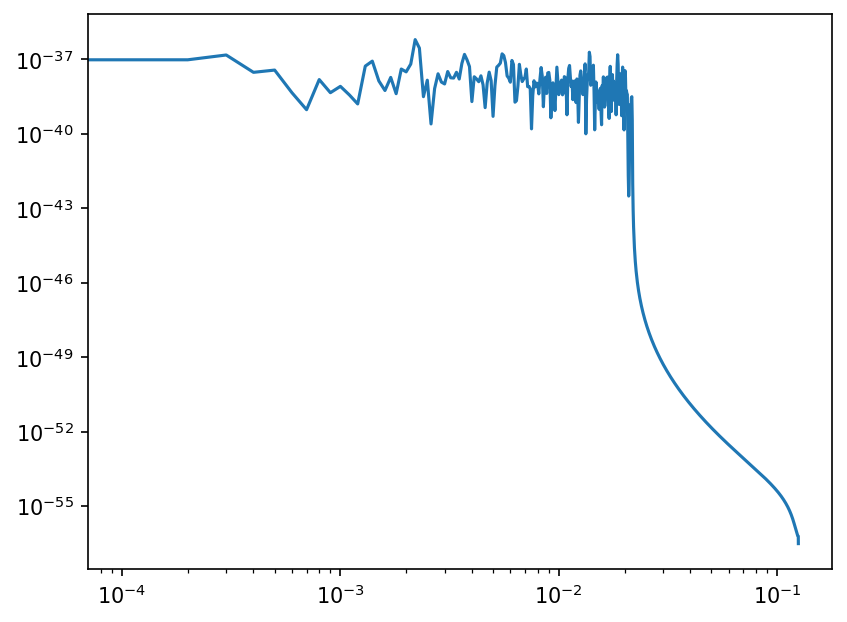

In [108]:
DL.plot_psd()

In [85]:
test_data = {'strain' : strain, 
             'time' : ts, 
             'injected_population' : injected_data, 
             'sample_rate' : 0.25, 
             'duration':10000,
             'limits' : limits
            }

In [92]:
write_nested_to_hdf5(test_data, "./test.hdf5")

sample_rate


In [87]:
A = read_hdf5_to_dict("./test.hdf5")
pd.DataFrame(A['injected_population'])

,amplitude,chirp_mass,frequency,luminosity_distance,phase,seperation
0,3.902395e-22,1.174577,0.000854,46.418467,5.007895,4.081029
1,4.805172e-22,1.247547,0.002446,41.681019,1.668739,2.065194
2,7.523643e-22,1.355037,0.014757,30.552240,4.153967,0.640565
3,9.206176e-22,1.322916,0.001459,23.989829,1.823658,2.972013
4,6.724984e-22,1.325679,0.011884,32.955312,6.178080,0.734650
...,...,...,...,...,...,...
995,7.569766e-22,1.257132,0.004554,26.798149,1.759073,1.368198
996,1.030514e-21,1.222694,0.011079,18.794404,1.865211,0.749378
997,4.231175e-22,1.244890,0.003457,47.167567,5.405292,1.638849
998,5.531859e-22,1.394029,0.020139,43.564701,1.979295,0.525604


In [ ]:
with h5py.File(filename, 'r') as f:
    